In [6]:
#%reset -f
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection #for plots polygons as rasters
import xarray as xr
from datetime import datetime, timedelta as delta
from matplotlib import path
from scipy.spatial import KDTree, cKDTree #c implementation is faster (to find nearest neighbor)
import os
import dask as da
from tqdm import tqdm
import glob
#for projections
from pyproj import Proj, transform, Transformer

In [7]:
#inputs----------
#path of directories
home_dir="/export/lv4/user/jfajardourbina/"
ml_dir=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/machine_learning_github/Lagrangian_ML/"
dir_wind=f"{home_dir}dws_ulf_getm_2D_depth_avg/data/atmosphere/" #winds
dir_topo=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_bathy_grid/" #topo data
dir_dws_bound=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_dws_boundaries/" #DWS boundarie with contour0
#dir_dis_mag=f"{home_dir}dws_ulf_getm_2D_depth_avg/data/dis_magocity/" #dis_mag data
file_topo="DWS200m.2012.v03.nc"
file_dws_bound0="dws_boundaries_contour0.nc"
#file_dis_mag="RE.DWS200m.uvz.20090301.nc" #any dis_mag file
file_wind0="UERRA.2009.nc4" #any wind file
#
#paths for output data
dir_post_proc_data=f"{ml_dir}post_proc_data/"
dir_displacement="net_displacement/" 

In [10]:
#open net displacement files---
files_displacement=sorted(glob.glob(f'{dir_post_proc_data}{dir_displacement}*.nc',recursive=True))
#files_displacement=files_displacement[29:31]
#concat all the files
dsdis=xr.open_mfdataset(files_displacement,concat_dim="time",parallel='True',chunks={'time': -1},
                      decode_cf=True, decode_times=True)#.load() #this are default decodes
                      #data_vars='minimal', coords='minimal', compat='override') #takes 1second more with this, see https://xarray.pydata.org/en/stable/io.html#reading-multi-file-datasets

In [11]:
xcdis0,ycdis0=dsdis.x,dsdis.y
xcdis,ycdis=np.meshgrid(xcdis0,ycdis0)

In [12]:
#open topo file
dsto=xr.open_dataset(dir_topo+file_topo) #topo file
xct0=dsto.xc.min().values/1e3; yct0=dsto.yc.min().values/1e3 #=(0,0)

#open DWS contours
dsb0=xr.open_dataset(dir_dws_bound+file_dws_bound0) 
bdr_dws0=dsb0.bdr_dws.values #points that define DWS with contour0

#create mask for islands
h=dsto.bathymetry; mask=h.where(np.isnan(h),1); mask=mask.where(np.isfinite(h),0)


#define the transformations------
#1)
#from epgs:28992(DWS) to epgs:4326(LatLon with WGS84 datum used by GPS and Google Earth)
proj = Transformer.from_crs('epsg:28992','epsg:4326',always_xy=True)
#2)
#from epgs:4326(LatLon with WGS84) to epgs:28992(DWS) 
inproj = Transformer.from_crs('epsg:4326','epsg:28992',always_xy=True)
#inproj_old=Proj("EPSG:28992") #old method (has errors 10-20m when contrast with the rotated coords)


# #lon,lat to 28992(DWS)-projection--------------------

#bathymetry--------
xct=dsto.lonc.values;  yct=dsto.latc.values #lon,lat units
xctp,yctp,z = inproj.transform(xct,yct,xct*0.)
#[xctp,yctp] = inproj_old(xct,yct) #old method
xctp=(xctp)/1e3; yctp=(yctp)/1e3 
#first projected point to correct the coordinates of model local meter units
xctp0=xctp[0,0]; yctp0=yctp[0,0]


#local meter model units to 28992(DWS)-projection and lon-lat--------------

#matrix rotation -17degrees-----
ang=-17*np.pi/180
angs=np.ones((2,2))
angs[0,0]=np.cos(ang); angs[0,1]=np.sin(ang)
angs[1,0]=-np.sin(ang); angs[1,1]=np.cos(ang)

#bathymetry----
#original topo points in meter
xct2,yct2=np.meshgrid(dsto.xc.values,dsto.yc.values)
xy=np.array([xct2.flatten(),yct2.flatten()]).T
#rotate
xyp=np.matmul(angs,xy.T).T/1e3
xyp0=xyp[0,:] #the first rotated point in the topo data in meter =0,0
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0,0]
#2)add the first projected point of the case (lon,lat model units to projection)
xyp=xyp-xyp0 
xyp[:,0]=xyp[:,0]+xctp0; xyp[:,1]=xyp[:,1]+yctp0 
xyp=np.reshape(xyp,(len(dsto.yc.values),len(dsto.xc.values),2))
xctp2=xyp[...,0]; yctp2=xyp[...,1] #km
#
#contrast projections (lon,lat model units to meter) with rotated case
#around 0 meter diff with new method
#10 meter difference in average and maximum of 20 with old method
a=xctp-xctp2; b=yctp-yctp2
print(np.abs(a).max()*1e3, np.abs(b).max()*1e3, np.abs(a).mean()*1e3, np.abs(b).mean()*1e3) 

#contour0 of DWS------
#rotate
bdr_dws0p=np.matmul(angs,bdr_dws0.T).T/1e3
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0]
#2)add the first projected point of the case (lon,lat model units to meter)
bdr_dws0p=bdr_dws0p-xyp0 
bdr_dws0p[:,0]=bdr_dws0p[:,0]+xctp0; bdr_dws0p[:,1]=bdr_dws0p[:,1]+yctp0
#
#get coordinates in lon-lat units (WGS84 ) 
bdr_dws0_lon, bdr_dws0_lat, z = proj.transform(bdr_dws0p[:,0]*1e3,bdr_dws0p[:,1]*1e3, bdr_dws0p[:,1]*0.)

#particle grid of displacements (use for convlstm)------
xy=np.array([xcdis.flatten(),ycdis.flatten()]).T
ny,nx=xcdis.shape
#rotate
xyp=np.matmul(angs,xy.T).T/1e3
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0,0]
#2)add the first projected point of the case (lon,lat model units to meter)
xyp=xyp-xyp0 
xyp[:,0]=xyp[:,0]+xctp0; xyp[:,1]=xyp[:,1]+yctp0 
xyp=np.reshape(xyp,(ny,nx,2))
xcdisp=xyp[...,0]; ycdisp=xyp[...,1] #km
#
#get coordinates in lon-lat units (WGS84 ) 
xcdisp_lon, ycdisp_lat, _ = proj.transform(xcdisp*1e3,ycdisp*1e3, ycdisp*0.)


#28992(DWS)-projection to local meter model units--------------

#matrix rotation 17degrees-----
ang2=17*np.pi/180
angs2=np.ones((2,2))
angs2[0]=np.cos(ang2); angs2[1]=np.sin(ang2)
angs2[1,0]=-np.sin(ang2); angs2[1,1]=np.cos(ang2)

#batymetry---
xy=np.array([xctp.flatten(),yctp.flatten()]).T #km
ny,nx=xctp.shape
#rotate
xyl=np.matmul(angs2,xy.T).T
xyl0=xyl[0,:] #the first point 
#correction from rotation to projection:
#1)substact the first rotated topo point in meter
#2)add the first local model point of the topo file
xyl=xyl-xyl0 
xyl[:,0]=xyl[:,0]+xct0; xyl[:,1]=xyl[:,1]+yct0 
xyl=np.reshape(xyl,(ny,nx,2))
xctl=xyl[...,0]; yctl=xyl[...,1] #km
#
#errors in the position when using the local values get from transformation (around 0.1% of the grid size)
a=abs(xctl*1e3-dsto.xc.values)
b=abs(yctl.T*1e3-dsto.yc.values)
print('max, mean, max% errors in x (m)',a.max(), a.mean(), a.max()/200*100,"%") # max=12cm, mean=5cm
print('max, mean, max% errors in y (m)',b.max(), b.mean(), b.max()/200*100,"%") # max=32cm, mean=13cm

0.026940217722426496 0.3400088997977946 0.009365292291273685 0.1443332403121348
max, mean, max% errors in x (m) 93383.54298962129 46691.64329984328 46691.771494810644 %
max, mean, max% errors in y (m) 0.32751821742022 0.13691407317063156 0.16375910871011 %


In [13]:
#rotate displacement from local coordinates to projection---
def model_local_coords_to_projection(x,y,ang=-17*np.pi/180):
    return np.cos(ang)*x + np.sin(ang)*y, -np.sin(ang)*x + np.cos(ang)*y

#rotate displacement from projection to model coordinates---
def projection_to_model_local_coords(x,y,ang=17*np.pi/180):
    return np.cos(ang)*x + np.sin(ang)*y, -np.sin(ang)*x + np.cos(ang)*y

2009-11-25T15:19:02.000000000


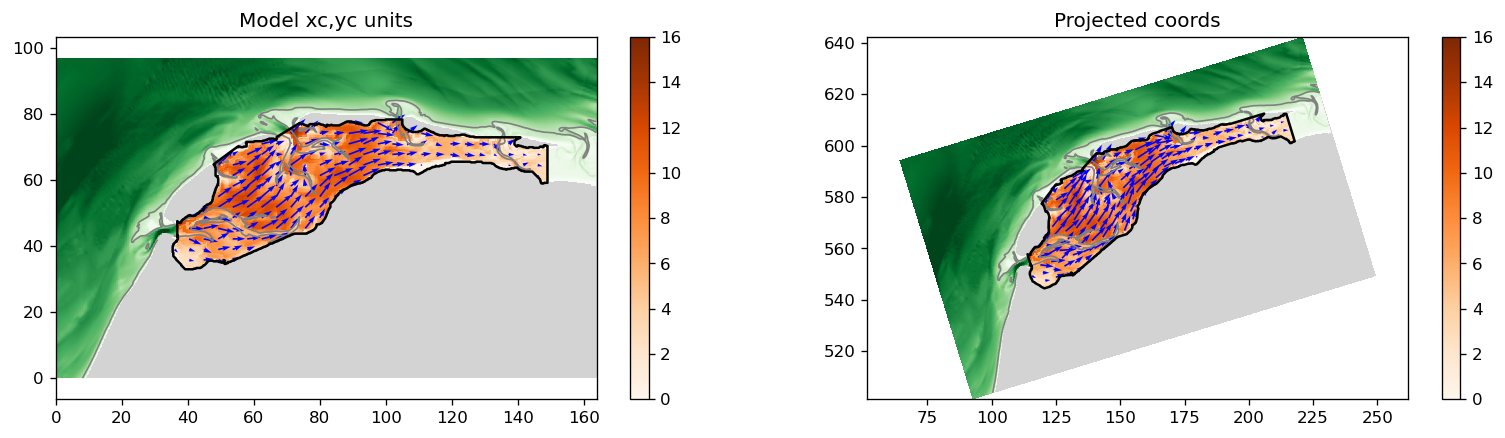

In [38]:
#checking the wind for a particular time---

fig,ax= plt.subplots(1,2,figsize=(16,4),dpi=120)

iyy=8;ixx=11
units='width';width=0.003;scale=300  
#it=100
it=np.nonzero(dsdis.time.values==np.datetime64("2009-11-25T15:19:02"))[0][0] #SW
#it=np.nonzero(dsdis.time.values==np.datetime64("2012-11-24T17:12:46"))[0][0] #SE
#after above SE during the next m2 interval a strong (SW), that only last in total: 2 M2 intervals
#it=np.nonzero(dsdis.time.values==np.datetime64("2012-11-24T17:12:46"))[0][0]+3 #strong SW
#dis_magocity in local coords---
dis_dx0=dsdis.dx.isel(time=it)
dis_dy0=dsdis.dy.isel(time=it)
dis_mag0=(dis_dx0**2+dis_dy0**2)**.5
#dis_magocity in projected coords---
#explicity (this is better because keep the xarray structure)
dis_dx0p,dis_dy0p=model_local_coords_to_projection(dis_dx0,dis_dy0)
#
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
#
ax[0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,vmin=-2,vmax=30,shading='auto',cmap=cmap)
aa=ax[0].pcolormesh(xcdis0/1e3,ycdis0/1e3,dis_mag0,vmin=0,vmax=16,shading='auto',cmap="Oranges") #wind correct orientation
plt.colorbar(aa,ax=ax[0])
ax[0].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k') #DWS limits
Q = ax[0].quiver(xcdis[::iyy,::ixx]/1e3,ycdis[::iyy,::ixx]/1e3,dis_dx0[::iyy,::ixx],dis_dy0[::iyy,::ixx],units=units,width=width,scale=scale,color='b')
#qk = ax[0].quiverkey(Q, .3, .2, 10, '10km', labelpos='E',coordinates='axes')
ax[0].axis('equal')#;ax[0].axis([30,150,30,80])
ax[0].set_title('Model xc,yc units');
#
ax[1].pcolormesh(xctp,yctp,dsto.bathymetry,vmin=-2,vmax=30,shading='auto',cmap=cmap)
aa=ax[1].pcolormesh(xcdisp,ycdisp,dis_mag0,vmin=0,vmax=16,shading='auto',cmap="Oranges") #wind correct orientation
plt.colorbar(aa,ax=ax[1])
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
Q = ax[1].quiver(xcdisp[::iyy,::ixx],ycdisp[::iyy,::ixx],dis_dx0p[::iyy,::ixx],dis_dy0p[::iyy,::ixx],units=units,width=width,scale=scale,color='b')
#qk = ax[1].quiverkey(Q, .3, .2, 10, '10km', labelpos='E',coordinates='axes')
ax[1].axis('equal');#ax[1].axis([30,150,30,80])
#plt.axis([80,250,530,630])
ax[1].set_title('Projected coords');

print(dsdis.time.isel(time=it).values)

In [9]:
%%time
#vectorial
dis_dx_mean_vec=dsdis.dx.mean(dim="time")
dis_dy_mean_vec=dsdis.dy.mean(dim="time")
dis_ang_mean=np.arctan2(dis_dy_mean_vec,dis_dx_mean_vec)
#scalar
dis_mag_mean=((dsdis.dx**2+dsdis.dy**2)**.5).mean(dim="time")
dis_dx_mean=dis_mag_mean*np.cos(dis_ang_mean)
dis_dy_mean=dis_mag_mean*np.sin(dis_ang_mean)
#compute
dis_dx_mean_vec,dis_dy_mean_vec,dis_dx_mean,dis_dy_mean=da.compute(dis_dx_mean_vec,dis_dy_mean_vec,dis_dx_mean,dis_dy_mean)
dis_mag_mean_vec=(dis_dx_mean_vec**2+dis_dy_mean_vec**2)**.5
dis_mag_mean=(dis_dx_mean**2+dis_dy_mean**2)**.5

CPU times: user 12.7 s, sys: 9.27 s, total: 22 s
Wall time: 6.07 s


/export/lv4/user/jfajardourbina/programs/miniconda3/envs/phd_parcelsv221/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


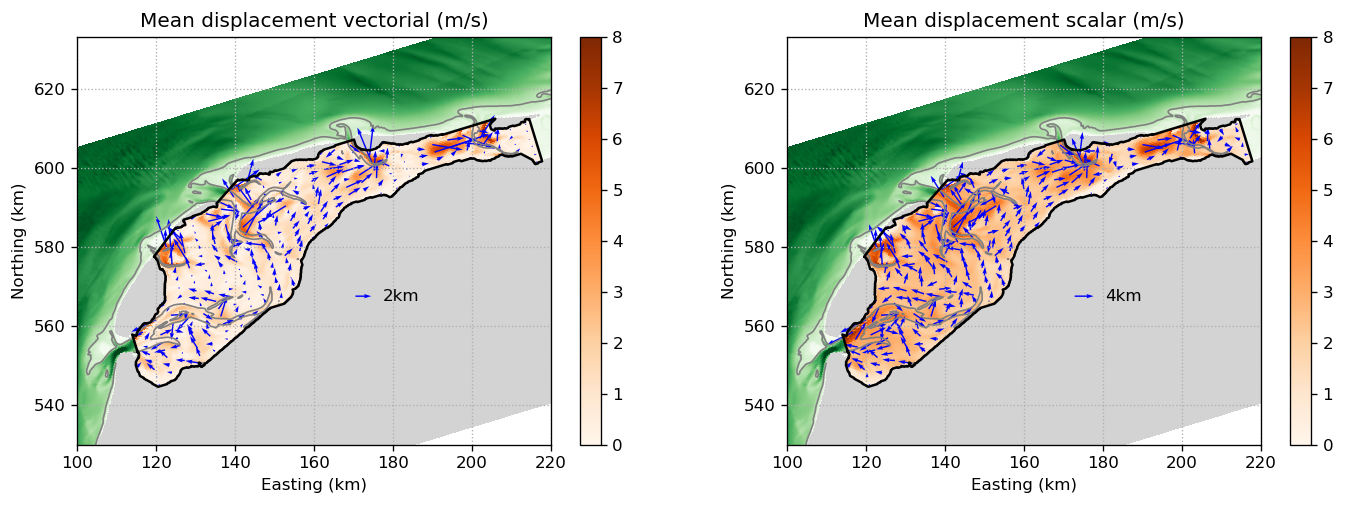

In [65]:
fig,ax= plt.subplots(1,2,figsize=(14,4.5),dpi=120)
#
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
#
#
iyy=5;ixx=10
units='width';width=0.003;scale=60  
ax[0].pcolormesh(xctp,yctp,dsto.bathymetry,vmin=-2,vmax=30,shading='auto',cmap=cmap)
aa=ax[0].pcolormesh(xcdisp,ycdisp,dis_mag_mean_vec,vmin=0,vmax=8,shading='auto',cmap="Oranges") #wind correct orientation
plt.colorbar(aa,ax=ax[0])
ax[0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0].axis('equal');ax[0].axis([100,220,543,620]);ax[0].grid(ls=":")
ax[0].set_xlabel('Easting (km)'); ax[0].set_ylabel('Northing (km)');
ax[0].set_title('Mean displacement vectorial (m/s)');
#vel_from_local_coords_to_projection
dis_dx_mean_vecp,dis_dy_mean_vecp=model_local_coords_to_projection(dis_dx_mean_vec,dis_dy_mean_vec)
Q = ax[0].quiver(xcdisp[::iyy,::ixx],ycdisp[::iyy,::ixx],dis_dx_mean_vecp[::iyy,::ixx],dis_dy_mean_vecp[::iyy,::ixx],units=units,width=width,scale=scale,color='b')
qk = ax[0].quiverkey(Q, 0.3, 0.4, 2, '2km', labelpos='E',coordinates='figure')
#
#
units='width';width=0.003;scale=100  
ax[1].pcolormesh(xctp,yctp,dsto.bathymetry,vmin=-2,vmax=30,shading='auto',cmap=cmap)
aa=ax[1].pcolormesh(xcdisp,ycdisp,dis_mag_mean,vmin=0,vmax=8,shading='auto',cmap="Oranges") #wind correct orientation
plt.colorbar(aa,ax=ax[1])
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1].axis('equal');ax[1].axis([100,220,543,620]);ax[1].grid(ls=":")
ax[1].set_xlabel('Easting (km)');ax[1].set_ylabel('Northing (km)');
ax[1].set_title('Mean displacement scalar (m/s)');
#vel_from_local_coords_to_projection
dis_dx_meanp,dis_dy_meanp=model_local_coords_to_projection(dis_dx_mean,dis_dy_mean)
Q = ax[1].quiver(xcdisp[::iyy,::ixx],ycdisp[::iyy,::ixx],dis_dx_meanp[::iyy,::ixx],dis_dy_meanp[::iyy,::ixx],units=units,width=width,scale=scale,color='b')
qk = ax[1].quiverkey(Q, 0.73, 0.4, 4, '4km', labelpos='E',coordinates='figure');


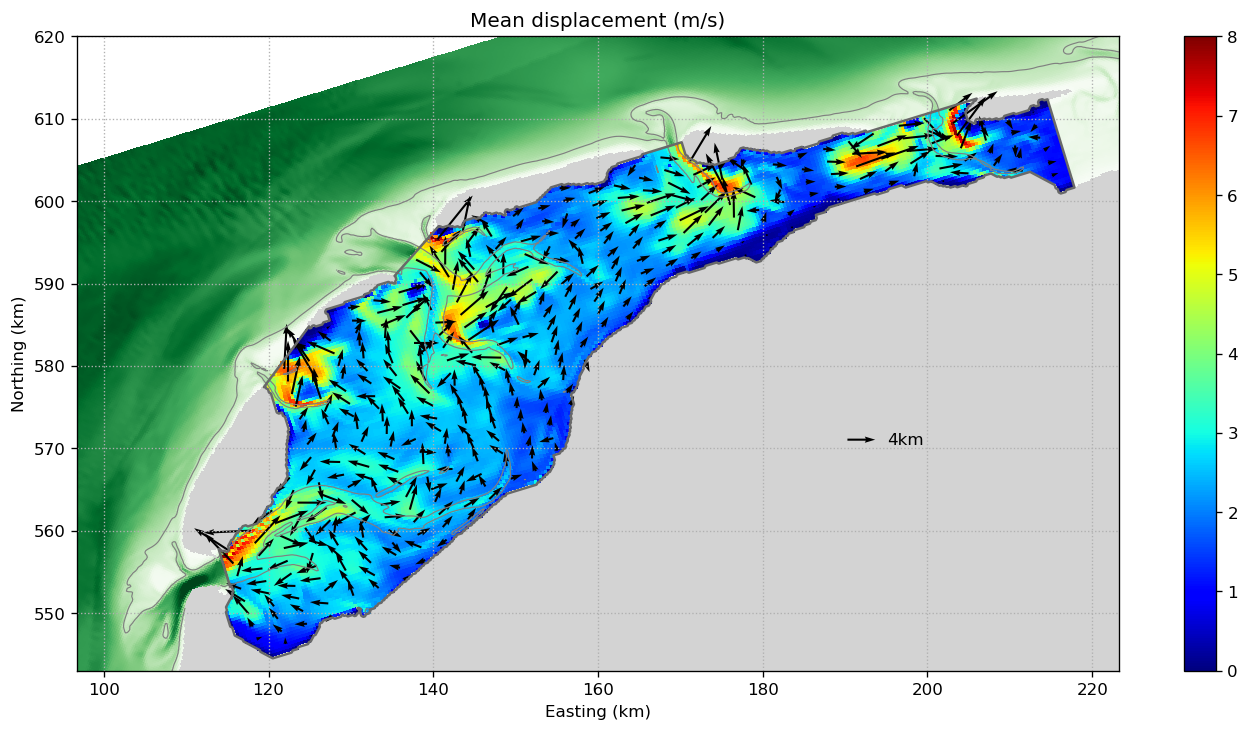

In [64]:
fig,ax= plt.subplots(1,1,figsize=(14,7),dpi=120)
#
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
#
iyy=4;ixx=8
units='width';width=0.002;scale=150  
ax.pcolormesh(xctp,yctp,dsto.bathymetry,vmin=-2,vmax=30,shading='auto',cmap=cmap)
aa=ax.pcolormesh(xcdisp,ycdisp,dis_mag_mean,vmin=0,vmax=8,shading='auto',cmap="jet") #wind correct orientation
plt.colorbar(aa,ax=ax)
ax.contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=.7) #bathy from topo file correct orientation
ax.plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'dimgrey') #DWS limits
ax.axis('equal');ax.axis([100,220,543,620]);ax.grid(ls=":")
ax.set_xlabel('Easting (km)');ax.set_ylabel('Northing (km)');
ax.set_title('Mean displacement (m/s)');
#vel_from_local_coords_to_projection
dis_dx_meanp,dis_dy_meanp=model_local_coords_to_projection(dis_dx_mean,dis_dy_mean)
Q = ax.quiver(xcdisp[::iyy,::ixx],ycdisp[::iyy,::ixx],dis_dx_meanp[::iyy,::ixx],dis_dy_meanp[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
qk = ax.quiverkey(Q, 0.6, 0.4, 4, '4km', labelpos='E',coordinates='figure');

### check histograms

#### using displacement components along model axes

In [14]:
%%time
dis_dx,dis_dy=da.compute(dsdis.dx.values,dsdis.dy.values)
dis_dx=dis_dx[np.isfinite(dis_dx)].flatten(); dis_dy=dis_dy[np.isfinite(dis_dy)].flatten()
dis_dx_mean=np.mean(dis_dx); dis_dx_median=np.median(dis_dx); dis_dx_std=np.std(dis_dx)
dis_dy_mean=np.mean(dis_dy); dis_dy_median=np.median(dis_dy); dis_dy_std=np.std(dis_dy)

CPU times: user 9.56 s, sys: 7.04 s, total: 16.6 s
Wall time: 16.6 s


CPU times: user 1min 3s, sys: 1.55 s, total: 1min 4s
Wall time: 1min 4s


Text(0.5, 0, '(km)')

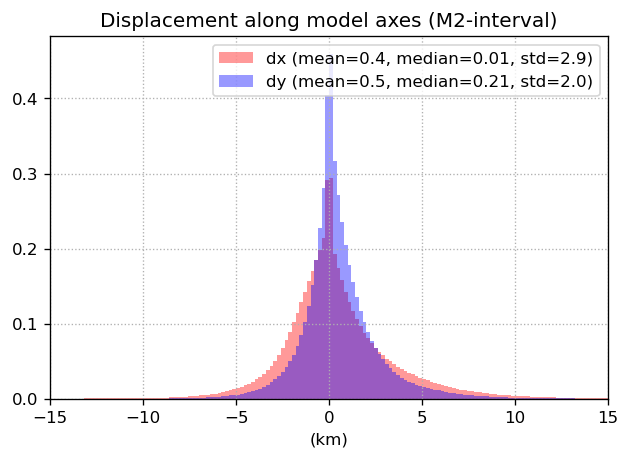

In [83]:
%%time
fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
#
ax.hist(dis_dx, bins=np.arange(-30,30.2,0.2), alpha=0.4, density=True, color='red', label=f'dx (mean={dis_dx_mean:.1f}, median={dis_dx_median:.2f}, std={dis_dx_std:.1f})');
ax.hist(dis_dy, bins=np.arange(-30,30.2,0.2), alpha=0.4, density=True, color='blue',label=f'dy (mean={dis_dy_mean:.1f}, median={dis_dy_median:.2f}, std={dis_dy_std:.1f})');
ax.set_xlim(-15,15);ax.legend(); ax.grid(ls=":");
ax.set_title("Displacement along model axes (M2-interval)");ax.set_xlabel("(km)");

In [4]:
# standarized----

CPU times: user 38.3 s, sys: 524 ms, total: 38.8 s
Wall time: 38.9 s


Text(0.5, 0, 'standarized')

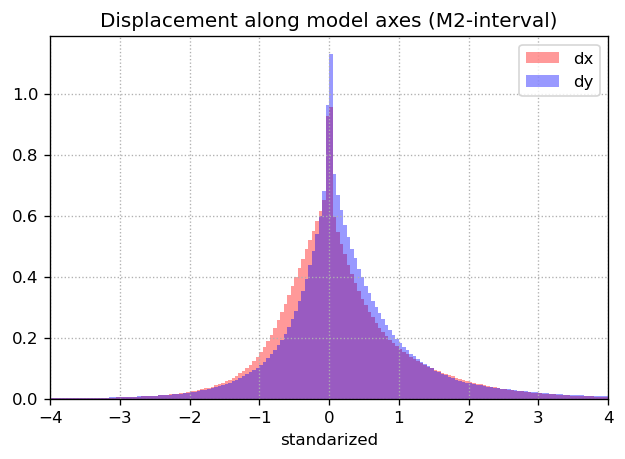

In [112]:
%%time
fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
#
ax.hist(dis_dx/dis_dx_std, bins=np.arange(-7,7.05,0.05), alpha=0.4, density=True, color='red', label=f'dx');
ax.hist(dis_dy/dis_dy_std, bins=np.arange(-7,7.05,0.05), alpha=0.4, density=True, color='blue',label=f'dy');
ax.set_xlim(-4,4);ax.legend(); ax.grid(ls=":");
ax.set_title("Displacement along model axes (M2-interval)");ax.set_xlabel("standarized");

CPU times: user 38.3 s, sys: 515 ms, total: 38.8 s
Wall time: 38.9 s


Text(0.5, 0, 'standarized (3std)')

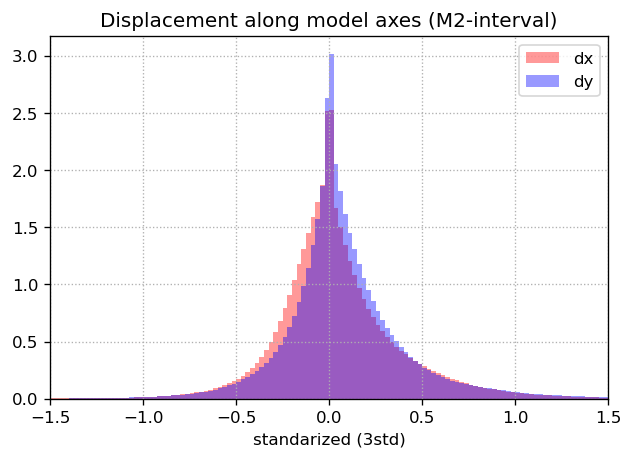

In [113]:
%%time
fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
#
ax.hist(dis_dx/(3*dis_dx_std), bins=np.arange(-3,3.025,0.025), alpha=0.4, density=True, color='red', label=f'dx');
ax.hist(dis_dy/(3*dis_dy_std), bins=np.arange(-3,3.025,0.025), alpha=0.4, density=True, color='blue',label=f'dy');
ax.set_xlim(-1.5,1.5);ax.legend(); ax.grid(ls=":");
ax.set_title("Displacement along model axes (M2-interval)");ax.set_xlabel("standarized (3std)");

CPU times: user 38.6 s, sys: 612 ms, total: 39.2 s
Wall time: 39.3 s


Text(0.5, 0, 'standarized (4std)')

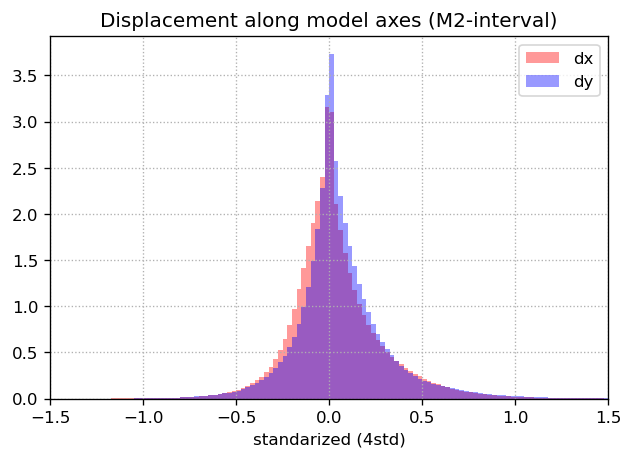

In [11]:
%%time
fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
#
ax.hist(dis_dx/(4*dis_dx_std), bins=np.arange(-3,3.025,0.025), alpha=0.4, density=True, color='red', label=f'dx');
ax.hist(dis_dy/(4*dis_dy_std), bins=np.arange(-3,3.025,0.025), alpha=0.4, density=True, color='blue',label=f'dy');
ax.set_xlim(-1.5,1.5);ax.legend(); ax.grid(ls=":");
ax.set_title("Displacement along model axes (M2-interval)");ax.set_xlabel("standarized (4std)");

CPU times: user 38.6 s, sys: 497 ms, total: 39.1 s
Wall time: 39.1 s


Text(0.5, 0, 'standarized (5std)')

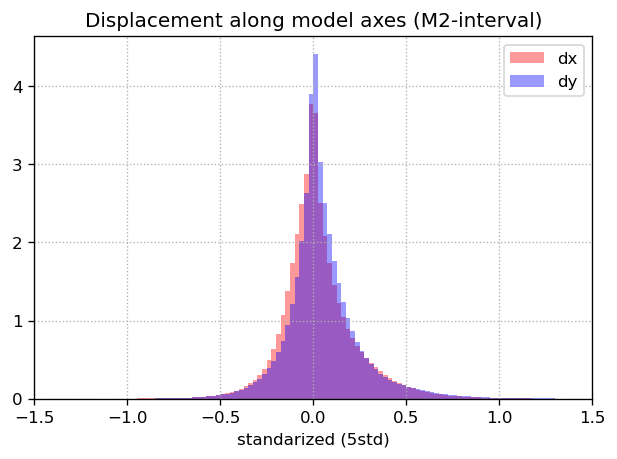

In [12]:
%%time
fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=120)
#
ax.hist(dis_dx/(5*dis_dx_std), bins=np.arange(-3,3.025,0.025), alpha=0.4, density=True, color='red', label=f'dx');
ax.hist(dis_dy/(5*dis_dy_std), bins=np.arange(-3,3.025,0.025), alpha=0.4, density=True, color='blue',label=f'dy');
ax.set_xlim(-1.5,1.5);ax.legend(); ax.grid(ls=":");
ax.set_title("Displacement along model axes (M2-interval)");ax.set_xlabel("standarized (5std)");

In [2]:
# normalization with min-max-scalar----

In [93]:
dis_dx_sc=(dis_dx-np.nanmin(dis_dx))/(np.nanmax(dis_dx)-np.nanmin(dis_dx));  #[0,1]
dis_dy_sc=(dis_dy-np.nanmin(dis_dy))/(np.nanmax(dis_dy)-np.nanmin(dis_dy)); 
dis_dx_sc=dis_dx_sc.values.flatten(); dis_dx_sc=dis_dx_sc[np.isfinite(dis_dx_sc)]
dis_dy_sc=dis_dy_sc.values.flatten(); dis_dy_sc=dis_dy_sc[np.isfinite(dis_dy_sc)]
#ws_std_sc2=2.*ws_std_sc-1 #[-1,1], give mean distribution close to -1 far away from ws distribution (not ok)
#
#also try to use the same min and max of the training for the validation and testing data
#because for production we don't know the targets, so it is better this approach
#
#So:
#- use min-max scalar with positive quantities
#- it preserves shape, we dont have to worry about the factor to multiply the std
#- it gives positive values, which is consistent with a magnitude

CPU times: user 37.9 s, sys: 3.58 ms, total: 37.9 s
Wall time: 38 s


Text(0.5, 0, 'min-max normalization')

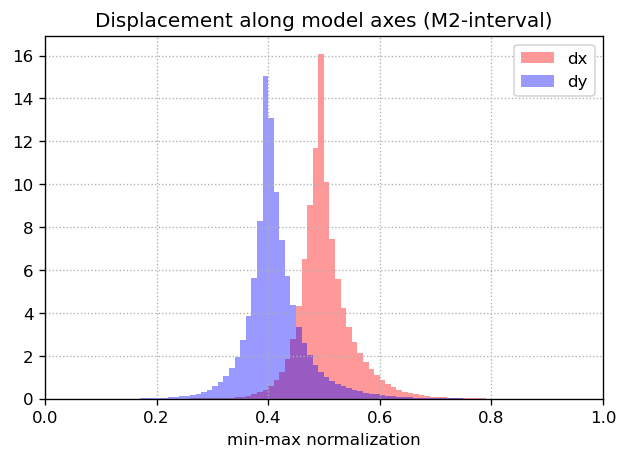

In [99]:
%%time
#so the difference between peaks of components using min-max change in comparision with original data---
plt.figure(figsize=(6,4),dpi=120)
plt.hist(dis_dx_sc, bins=np.arange(0,1.01,0.01), alpha=0.4, density=True, color='red',label="dx");
plt.hist(dis_dy_sc, bins=np.arange(0,1.01,0.01), alpha=0.4, density=True, color='blue',label="dy");
plt.xlim(0,1); plt.legend(); plt.grid(ls=":")
plt.title("Displacement along model axes (M2-interval)");plt.xlabel("min-max normalization");

#### Using speed and direction

In [1]:
#We can not use this, because on land we have nan
#if we fill angles with 0, we will have strong change around coast, and the convolution will be a mess

In [15]:
dis_mag = (dis_dx**2+dis_dy**2)**.5
dis_ang = np.arctan2(dis_dy,dis_dx)*180/np.pi

CPU times: user 38.4 s, sys: 6.6 ms, total: 38.4 s
Wall time: 38.4 s


Text(0.5, 0, '(km)')

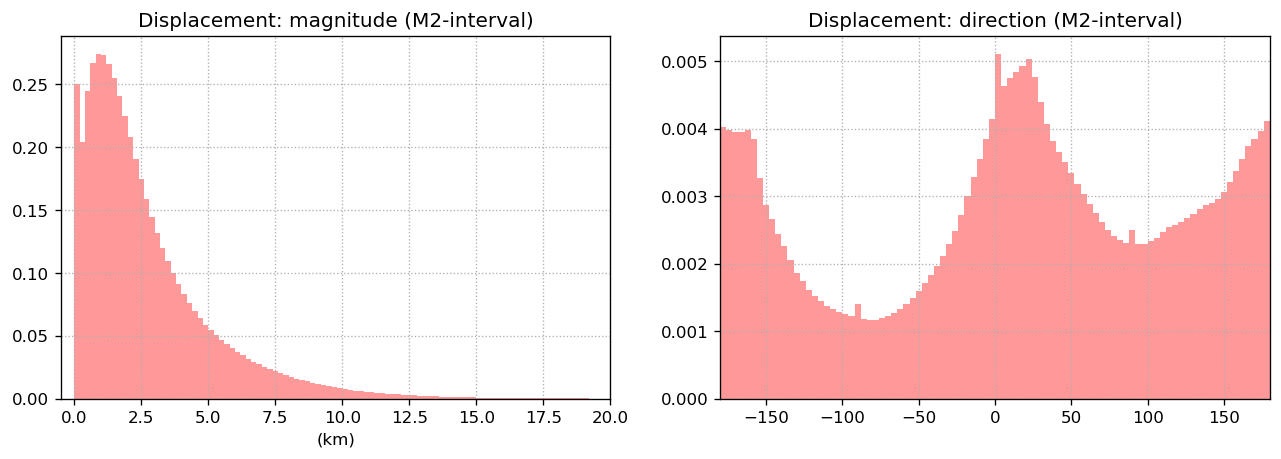

In [129]:
%%time
fig,ax=plt.subplots(1,2,figsize=(13,4),dpi=120)
ax[0].hist(dis_mag, bins=np.arange(0,31.2,0.2), alpha=0.4, density=True, color='red');
ax[0].set_xlim(-.5,20); ax[0].grid(ls=":")
ax[0].set_title("Displacement: magnitude (M2-interval)");ax[0].set_xlabel("(km)");
ax[1].hist(dis_ang, bins=np.arange(-180,184,4), alpha=0.4, density=True, color='red');
ax[1].set_xlim(-180,180); ax[1].grid(ls=":"); ax[1].set_ylim(0,0.0055)
ax[1].set_title("Displacement: direction (M2-interval)");ax[0].set_xlabel("(km)");

In [16]:
#wind direction with respect to zonal axis----
#
wd_vals_lon0=np.arange(-180,180+1,45) #directions with respect to zonal direction
#wd_vals_xc0=wd_vals_lon0-17 #with respect to loca model x-axis, however have to modify when beyond -/+180
wd_labs=["E","NE","N","NW","W","SW","S","SE","E"]
#
dis_ang2=dis_ang*1.+17
dis_ang2[dis_ang2>180] = dis_ang2[dis_ang2>180]-360

CPU times: user 38.6 s, sys: 251 ms, total: 38.9 s
Wall time: 38.9 s


Text(0.5, 0, '(km)')

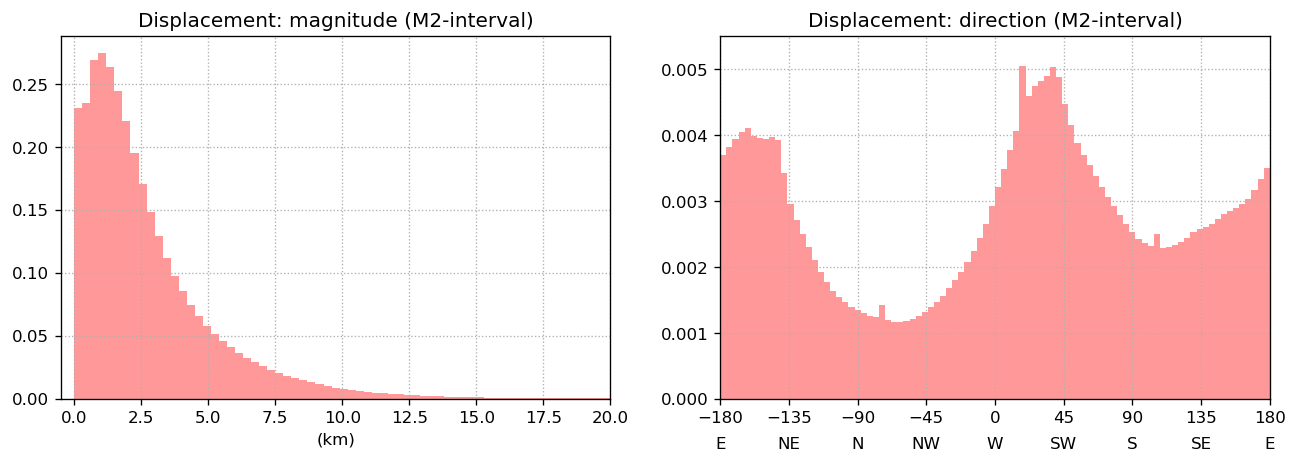

In [17]:
%%time
fig,ax=plt.subplots(1,2,figsize=(13,4),dpi=120)
ax[0].hist(dis_mag, bins=np.arange(0,31.3,0.3), alpha=0.4, density=True, color='red');
ax[0].set_xlim(-.5,20); ax[0].grid(ls=":")
ax[0].set_title("Displacement: magnitude (M2-interval)");ax[0].set_xlabel("(km)");
ax[1].hist(dis_ang2, bins=np.arange(-180,184,4), alpha=0.4, density=True, color='red');
ax[1].set_xlim(-180,180);ax[1].set_xticks(range(-180,180+45,45)); ax[1].grid(ls=":")
for i,val in enumerate(wd_vals_lon0): ax[1].text(val,-.00075,wd_labs[i],ha="center"); ax[1].set_ylim(0,0.0055)
ax[1].set_title("Displacement: direction (M2-interval)");ax[0].set_xlabel("(km)");

In [150]:
#using min-max-scalar
dis_mag_sc=(dis_mag-np.nanmin(dis_mag))/(np.nanmax(dis_mag)-np.nanmin(dis_mag));  #[0,1]
#
#also try to use the same min and max of the training for the validation and testing data
#because for production we don't know the targets, so it is better this approach
#
#So:
#- use min-max scalar with positive quantities
#- it preserves shape, we dont have to worry about the factor to multiply the std
#- it gives positive values, which is consistent with a magnitude

No handles with labels found to put in legend.


CPU times: user 19.1 s, sys: 7.53 ms, total: 19.1 s
Wall time: 19.1 s


Text(0.5, 0, 'min-max normalization')

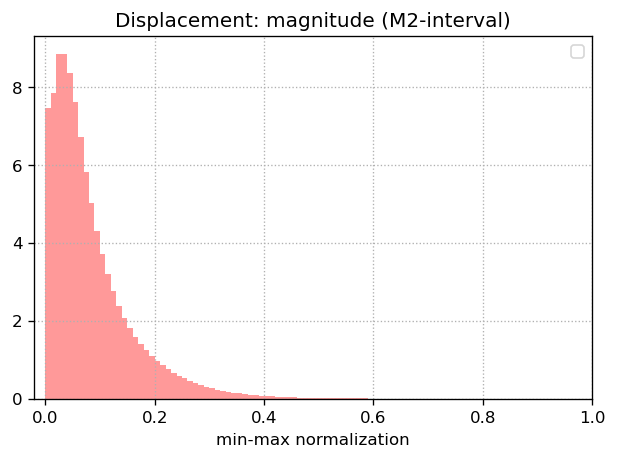

In [157]:
%%time
plt.figure(figsize=(6,4),dpi=120)
plt.hist(dis_mag_sc, bins=np.arange(0,1.01,0.01), alpha=0.4, density=True, color='red');
plt.xlim(-.02,1); plt.legend(); plt.grid(ls=":")
plt.title("Displacement: magnitude (M2-interval)");plt.xlabel("min-max normalization");